## Lê Thành Danh: EXPLORATORY DATA ANALYSIS & CLUSTERING - PHÂN TÍCH KHÁM PHÁ DỮ LIỆU (EDA) & PHÂN CỤM



### 1. Khai báo thư viện

In [1]:
# 1. Khai báo thư viện

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

### 2. Tải dữ liệu

In [2]:
# 2. Tải dữ liệu
print("PHẦN 1: Phân tích khám dữ liệu (EDA)")

df = pd.read_csv('data/cleaned_data.csv')
print(f"\n Đã load cleaned data: {df.shape[0]:,} rows × {df.shape[1]} columns")

PHẦN 1: Phân tích khám dữ liệu (EDA)

 Đã load cleaned data: 99,457 rows × 29 columns


### 3. Phân tích đơn biến (Univariate Analysis)

3.1 Phân tích đơn biến (Univariate Analysis)


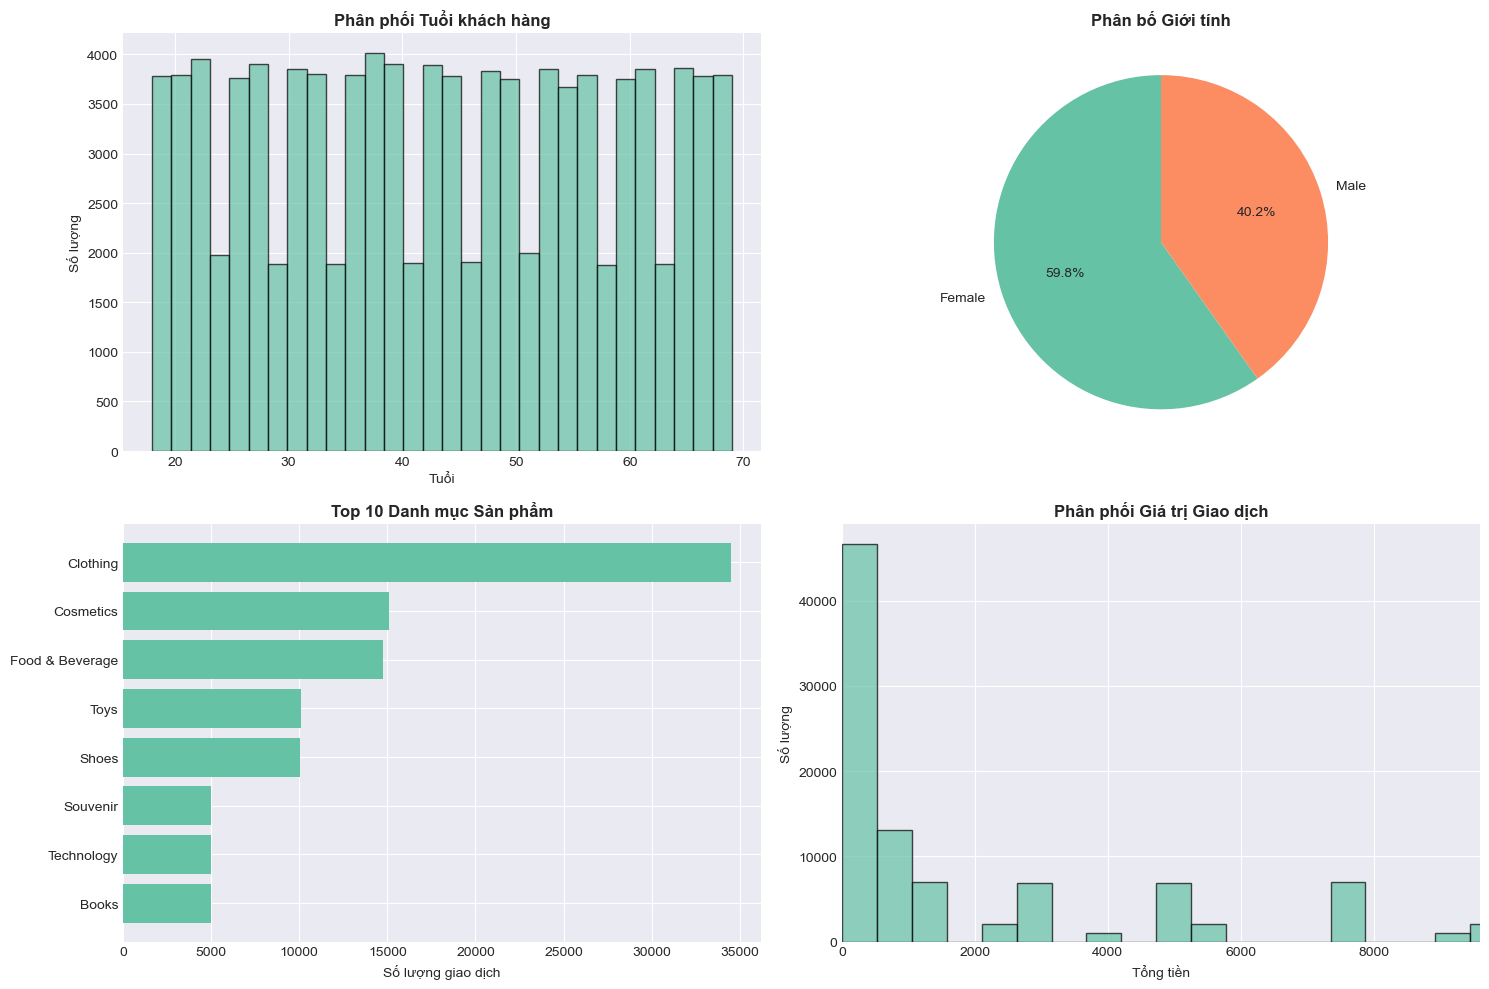

Đã lưu: figures/01_univariate_analysis.png


In [3]:
# 3. Phân tích đơn biến (Univariate Analysis)

print("3.1 Phân tích đơn biến (Univariate Analysis)")

# 3.1 Phân phối Age
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Phân bố độ tuổi
axes[0, 0].hist(df['age'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Phân phối Tuổi khách hàng', fontweight='bold')
axes[0, 0].set_xlabel('Tuổi')
axes[0, 0].set_ylabel('Số lượng')

# Phân bố giới tính
gender_counts = df['gender'].value_counts()
axes[0, 1].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Phân bố Giới tính', fontweight='bold')

# Phân bố danh mục
if 'category' in df.columns:
    cat_counts = df['category'].value_counts().head(10)
    axes[1, 0].barh(cat_counts.index, cat_counts.values)
    axes[1, 0].set_title('Top 10 Danh mục Sản phẩm', fontweight='bold')
    axes[1, 0].set_xlabel('Số lượng giao dịch')
    axes[1, 0].invert_yaxis()

# Phân bố tổng số tiền chi tiêu
if 'total_amount' in df.columns:
    axes[1, 1].hist(df['total_amount'], bins=50, edgecolor='black', alpha=0.7)
    axes[1, 1].set_title('Phân phối Giá trị Giao dịch', fontweight='bold')
    axes[1, 1].set_xlabel('Tổng tiền')
    axes[1, 1].set_ylabel('Số lượng')
    axes[1, 1].set_xlim(0, df['total_amount'].quantile(0.95))

plt.tight_layout()
plt.savefig('figures/01_univariate_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: figures/01_univariate_analysis.png")

### 4. Phân tích đa biến (Bivariate Analysis)

3.2 Phân tích đa biến (Bivariate Analysis)


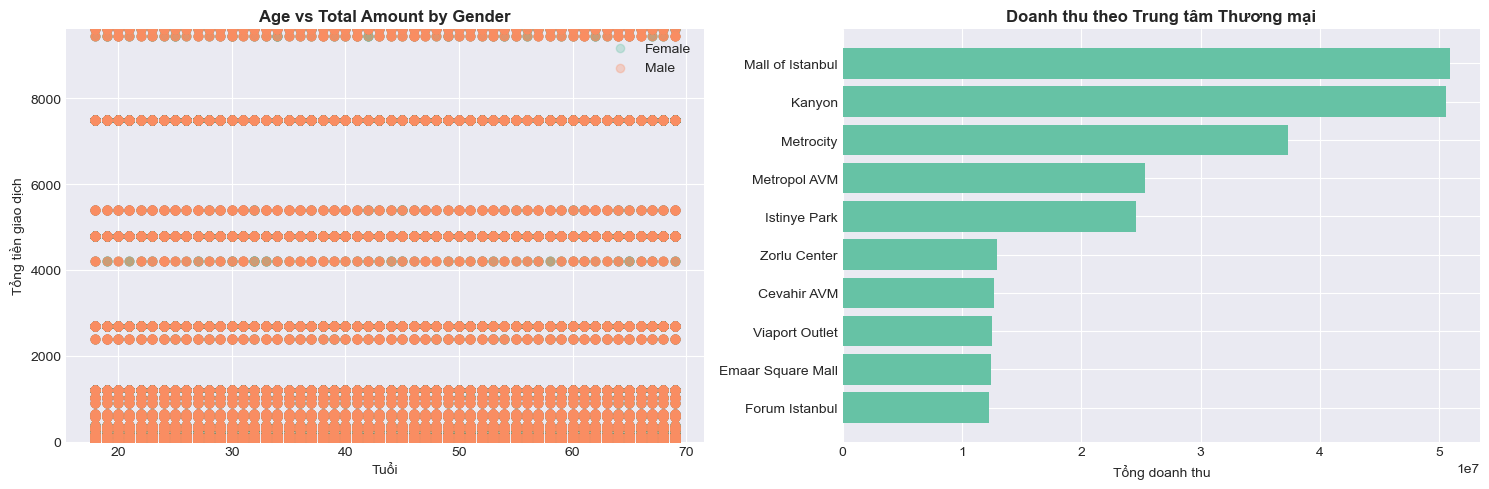

Đã lưu: figures/02_bivariate_analysis.png


In [4]:
# 4. Phân tích đa biến (Bivariate Analysis)

print("3.2 Phân tích đa biến (Bivariate Analysis)")

# Mối quan hệ giữa độ tuổi và tổng chi tiêu theo giới tính
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

if all(col in df.columns for col in ['age', 'total_amount', 'gender']):
    for gender in df['gender'].unique():
        data = df[df['gender'] == gender]
        axes[0].scatter(data['age'], data['total_amount'], alpha=0.3, label=gender)
    axes[0].set_xlabel('Tuổi')
    axes[0].set_ylabel('Tổng tiền giao dịch')
    axes[0].set_title('Age vs Total Amount by Gender', fontweight='bold')
    axes[0].legend()
    axes[0].set_ylim(0, df['total_amount'].quantile(0.95))

# Doanh thu của trung tâm thương mại
if 'shopping_mall' in df.columns and 'total_amount' in df.columns:
    mall_revenue = df.groupby('shopping_mall')['total_amount'].sum().sort_values(ascending=False)
    axes[1].barh(mall_revenue.index, mall_revenue.values)
    axes[1].set_xlabel('Tổng doanh thu')
    axes[1].set_title('Doanh thu theo Trung tâm Thương mại', fontweight='bold')
    axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('figures/02_bivariate_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: figures/02_bivariate_analysis.png")

### 5. Phân tích theo thời gian (Temporal Analysis)

3.3. Phân tích theo thời gian (Temporal Analysis)


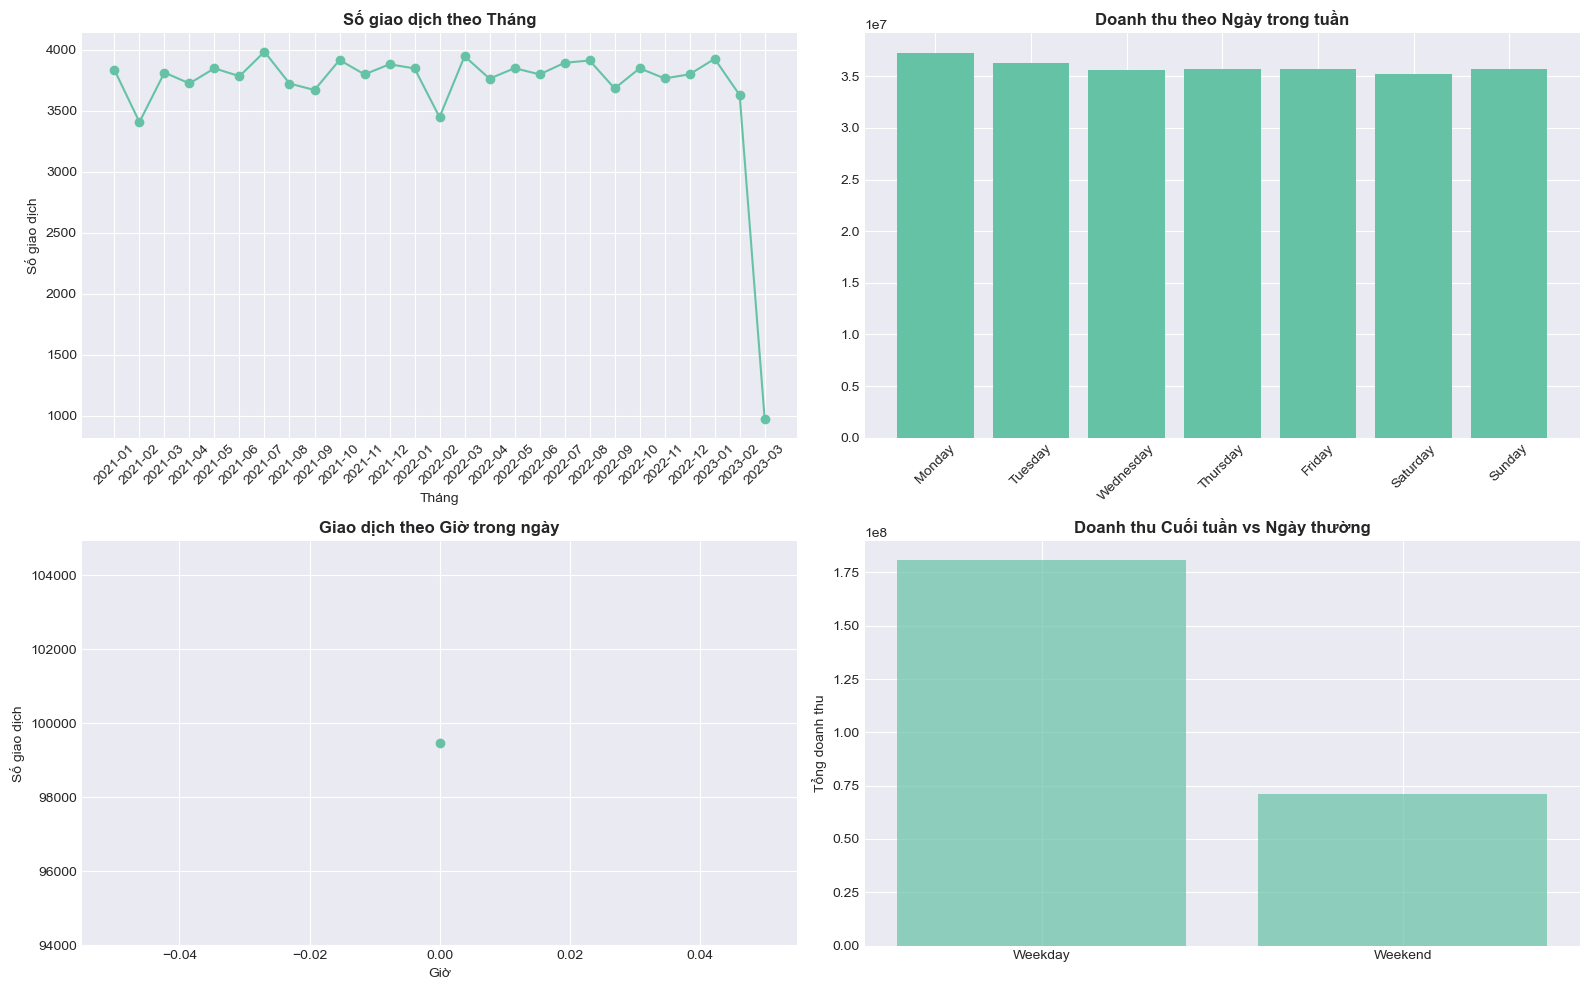

Đã lưu: figures/03_temporal_analysis.png


In [5]:
# 5. Phân tích theo thời gian (Temporal Analysis)

print("3.3. Phân tích theo thời gian (Temporal Analysis)")

if 'invoice_date' in df.columns:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Số lượng giao dịch theo tháng
    monthly_trans = df.groupby(df['invoice_date'].dt.to_period('M')).size()
    axes[0, 0].plot(monthly_trans.index.astype(str), monthly_trans.values, marker='o')
    axes[0, 0].set_title('Số giao dịch theo Tháng', fontweight='bold')
    axes[0, 0].set_xlabel('Tháng')
    axes[0, 0].set_ylabel('Số giao dịch')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Doanh thu theo từng ngày trong tuần
    if 'day_name' in df.columns and 'total_amount' in df.columns:
        dow_revenue = df.groupby('day_name')['total_amount'].sum()
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        dow_revenue = dow_revenue.reindex(day_order)
        axes[0, 1].bar(dow_revenue.index, dow_revenue.values)
        axes[0, 1].set_title('Doanh thu theo Ngày trong tuần', fontweight='bold')
        axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Số lượng giao dịch theo từng giờ
    if 'hour' in df.columns:
        hourly_trans = df['hour'].value_counts().sort_index()
        axes[1, 0].plot(hourly_trans.index, hourly_trans.values, marker='o')
        axes[1, 0].set_title('Giao dịch theo Giờ trong ngày', fontweight='bold')
        axes[1, 0].set_xlabel('Giờ')
        axes[1, 0].set_ylabel('Số giao dịch')
        axes[1, 0].grid(True)
    
    # So sánh giao dịch giữa cuối tuần và ngày trong tuần
    if 'is_weekend' in df.columns and 'total_amount' in df.columns:
        weekend_data = df.groupby('is_weekend')['total_amount'].agg(['sum', 'mean'])
        labels = ['Weekday', 'Weekend']
        axes[1, 1].bar(labels, weekend_data['sum'].values, alpha=0.7)
        axes[1, 1].set_title('Doanh thu Cuối tuần vs Ngày thường', fontweight='bold')
        axes[1, 1].set_ylabel('Tổng doanh thu')
    
    plt.tight_layout()
    plt.savefig('figures/03_temporal_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Đã lưu: figures/03_temporal_analysis.png")

### 6. Phân tích tương quan (Correlation Analysis)

3.4 Phân tích tương quan (Correlation Analysis)


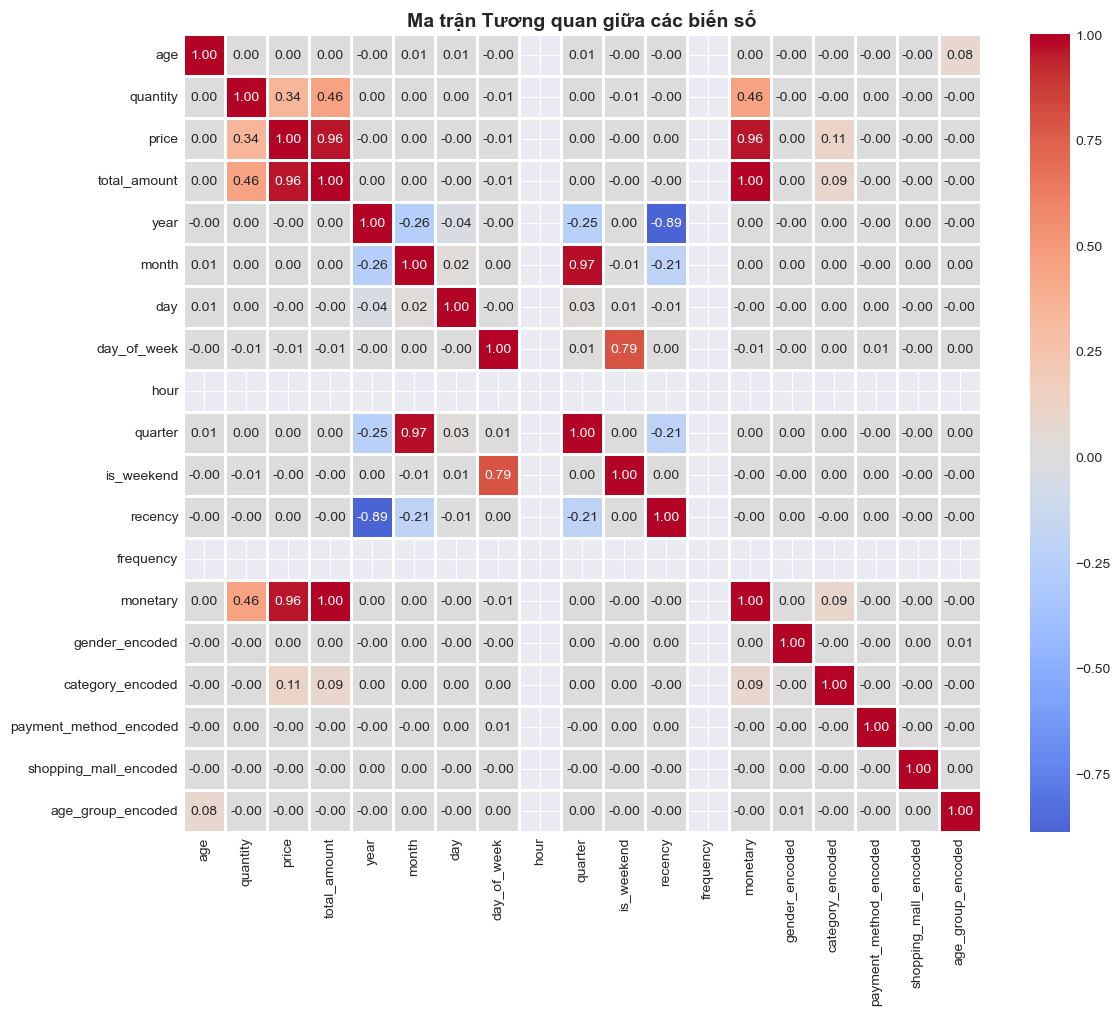

Đã lưu: figures/04_correlation_matrix.png


In [6]:
# 6. Phân tích tương quan (Correlation Analysis)

print("3.4 Phân tích tương quan (Correlation Analysis)")

numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Ma trận Tương quan giữa các biến số', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/04_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu: figures/04_correlation_matrix.png")